In [20]:
import logging

import torch
import torch.optim as optim

from robustbench.data import load_cifar10c
from robustbench.model_zoo.enums import ThreatModel
from robustbench.utils import load_model
from nets import *

import time
import tent
import norm
import oracle
from utils import *
from matplotlib import pyplot as plt


import ipdb

from conf import cfg, load_cfg_fom_args, merge_from_file

corruption_list = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness',
                        'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']


In [21]:
logger = logging.getLogger(__name__)
merge_from_file('cfgs/multistage.yaml')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(cfg)
print(device)

BN:
  EPS: 1e-05
  MOM: 0.1
CKPT_DIR: ./ckpt
CORRUPTION:
  DATASET: cifar10
  NUM_EX: 10000
  SEVERITY: [5]
  TYPE: ['gaussian_noise']
CUDNN:
  BENCHMARK: True
DATA_DIR: /gallery_tate/wonjae.roh
DESC: 
EPOCH: 50
EXPERIMENTAL:
  LINEAR_RETRAIN: False
ITERATION: 1
LOG_DEST: log.txt
LOG_TIME: 
MODEL:
  ADAPTATION: tent
  ARCH: RN18
  EPISODIC: False
OPTIM:
  BETA: 0.9
  DAMPENING: 0.0
  LR: 0.001
  METHOD: Adam
  MOMENTUM: 0.9
  NESTEROV: True
  STEPS: 2
  WD: 0.0
RNG_SEED: 1
SAVE_DIR: ./output
TEST:
  BATCH_SIZE: 200
cuda


### adaptation 없이 initial high_entropy samples, low_entropy samples index 찾기

In [22]:
def setup_tent(model):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    model = tent.configure_model(model)
    params, param_names = tent.collect_params(model)
    optimizer = setup_optimizer(params)
    tent_model = tent.Tent(model, optimizer,
                           steps=cfg.OPTIM.STEPS,
                           episodic=cfg.MODEL.EPISODIC)
    logger.info(f"model for adaptation: %s", model)
    logger.info(f"params for adaptation: %s", param_names)
    logger.info(f"optimizer for adaptation: %s", optimizer)
    return tent_model

def setup_pl(model):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    model = tent.configure_model(model)
    params, param_names = tent.collect_params(model)
    optimizer = setup_optimizer(params)
    pl_model = tent.PL(model, optimizer,
                           steps=cfg.OPTIM.STEPS,
                           episodic=cfg.MODEL.EPISODIC)
    logger.info(f"model for adaptation: %s", model)
    logger.info(f"params for adaptation: %s", param_names)
    logger.info(f"optimizer for adaptation: %s", optimizer)
    return pl_model

def setup_optimizer(params):
    """Set up optimizer for tent adaptation.

    Tent needs an optimizer for test-time entropy minimization.
    In principle, tent could make use of any gradient optimizer.
    In practice, we advise choosing Adam or SGD+momentum.
    For optimization settings, we advise to use the settings from the end of
    trainig, if known, or start with a low learning rate (like 0.001) if not.

    For best results, try tuning the learning rate and batch size.
    """
    if cfg.OPTIM.METHOD == 'Adam':
        return optim.Adam(params,
                    lr=cfg.OPTIM.LR,
                    betas=(cfg.OPTIM.BETA, 0.999),
                    weight_decay=cfg.OPTIM.WD)
    elif cfg.OPTIM.METHOD == 'SGD':
        return optim.SGD(params,
                   lr=cfg.OPTIM.LR,
                   momentum=cfg.OPTIM.MOMENTUM,
                   dampening=cfg.OPTIM.DAMPENING,
                   weight_decay=cfg.OPTIM.WD,
                   nesterov=cfg.OPTIM.NESTEROV)
    else:
        raise NotImplementedError
    
def setup_source(model):
    """Set up the baseline source model without adaptation."""
    model.eval()
    logger.info(f"model for evaluation: %s", model)
    return model

In [23]:

# configure model

if cfg.MODEL.ARCH == "Hendrycks2020AugMix_WRN":
    base_model = load_model(cfg.MODEL.ARCH, cfg.CKPT_DIR, cfg.CORRUPTION.DATASET, ThreatModel.corruptions).to(device)
elif cfg.MODEL.ARCH == "RN18":
    base_model = ResNet18(n_classes=10).to(device)
    ckpt = torch.load("/home2/wonjae.roh/nprc/tent/ckpt/cifar10/corruptions/ResNet18_pretrained.pth.tar", map_location=device)
    base_model.load_state_dict(ckpt["pretrain-learner"])
else:
    raise NotImplementedError


x_test, y_test = load_cifar10c(cfg.CORRUPTION.NUM_EX, cfg.CORRUPTION.SEVERITY[0], cfg.DATA_DIR, False, cfg.CORRUPTION.TYPE)
x_test, y_test = x_test.to(device), y_test.to(device)

acc, outputs = get_stats(base_model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True)



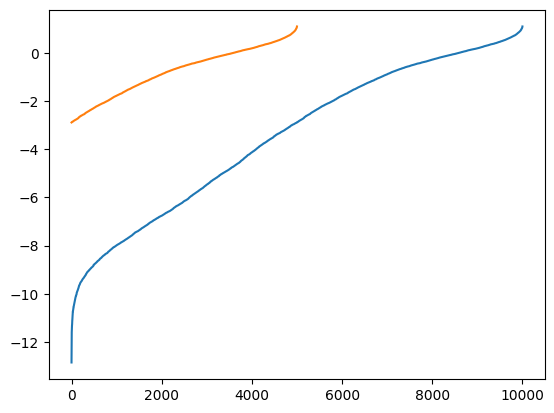

In [24]:
%matplotlib inline

entropy = tent.softmax_entropy(outputs)
entropy = torch.log2(entropy)
entropy_sorted, entropy_sorted_index = entropy.sort()
plt.plot(entropy_sorted.numpy())

high_index = entropy_sorted_index[5000:]
low_index = entropy_sorted_index[:5000]
high_values = entropy[high_index]
low_values = entropy[low_index]
plt.plot(high_values.numpy())

### Correct samples, Wrong samples entropy histogram visualize

                 0
count  6650.000000
mean     -4.490294
std       3.051585
min     -12.851542
25%      -7.051769
50%      -4.654666
75%      -1.754229
max       1.014241
                 0
count  3350.000000
mean     -1.380729
std       2.067541
min     -10.295473
25%      -2.323650
50%      -0.614420
75%       0.114202
max       1.095908


(array([  3.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   2.,   2.,
          2.,   2.,   3.,   2.,   2.,   1.,   4.,   3.,   2.,   2.,   5.,
          5.,   4.,   2.,   7.,   5.,   6.,   9.,   8.,  10.,   4.,   8.,
         11.,  13.,   9.,  11.,   6.,   8.,   9.,  13.,  12.,  11.,  13.,
         18.,  14.,  20.,  12.,  16.,  19.,  12.,  12.,  17.,  26.,  24.,
         15.,  25.,  19.,  25.,  24.,  27.,  29.,  27.,  28.,  42.,  32.,
         30.,  27.,  39.,  37.,  34.,  45.,  45.,  31.,  50.,  55.,  49.,
         52.,  57.,  69.,  50.,  71.,  63.,  76.,  91.,  93., 114., 124.,
        131., 157., 165., 170., 151., 150., 126.,  96.,  82.,  61.,  33.,
         20.]),
 array([-10.2954731 , -10.18155956, -10.06764507,  -9.95373154,
         -9.839818  ,  -9.72590446,  -9.61198997,  -9.49807644,
         -9.3841629 ,  -9.27024841,  -9.15633488,  -9.04242134,
         -8.9285078 ,  -8.81459332,  -8.70067978,  -8.58676624,
         -8.47285175,  -8.35893822,  -8.24502468,  -8.13111115

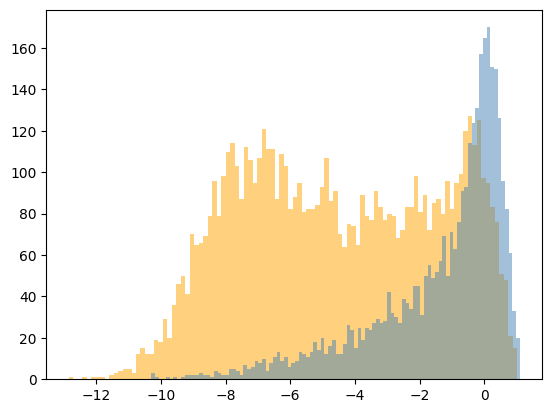

In [25]:
import pandas as pd

data_dir = "/gallery_tate/wonjae.roh/cifar10c"
labels_path = data_dir + '/labels.npy'
labels = np.load(labels_path)
# labels는 10000 sample, 5 severity에 대해 10000개의 같은 label이 5번 반복되는 형태이므로 잘라준다
labels = labels[:10000]

predicted = outputs.argmax(axis=1).numpy()

correct = predicted==labels
wrong = ~correct
entropy_numpy = entropy.numpy()

correct_entropy = entropy_numpy[correct]
wrong_entropy = entropy_numpy[wrong]

correct_describe = pd.DataFrame(correct_entropy)
print(correct_describe.describe())
wrong_describe = pd.DataFrame(wrong_entropy)
print(wrong_describe.describe())

plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [26]:
threshold = entropy_sorted[5000].item()
print(f'threshold : {threshold:.4f}') 

correct_high = np.sum(correct_describe > threshold)
correct_low = np.sum(correct_describe < threshold)
wrong_high = np.sum(wrong_describe > threshold)
wrong_low = np.sum(wrong_describe < threshold)

low_error = 100-float(correct_low * 100 / (correct_low + wrong_low))
high_error = 100-float(correct_high * 100 / (correct_high + wrong_high))
total_error = (low_error + high_error) / 2
                       
print(f'low_error : {low_error:.2f}')
print(f'high_error : {high_error:.2f}') 
print(f'total_error : {total_error:.2f}') 

threshold : -2.8889
low_error : 13.48
high_error : 53.51
total_error : 33.50


### Dataloader (low_entropy, high_entropy, all)

In [27]:
def get_subset(x, y, indices, shuffle=False):
    """get subset of data from indices
    Args:
    x: data
    y: labels
    indices: indices to get subset
    Returns:
    subset of data and labels
    """
    x_sub = x[indices]
    y_sub = y[indices]

    if shuffle:
        rand_idx = np.random.permutation(np.arange(len(x_sub)))
        x_sub, y_sub = x_sub[rand_idx], y_sub[rand_idx]

    return x_sub, y_sub
        
x_low, y_low = get_subset(x_test, y_test, low_index, shuffle=True)
x_high, y_high = get_subset(x_test, y_test, high_index, shuffle=True)     

### adaptation with suitable dataset (all)

In [28]:
def vis_entropy_histogram(outputs, labels):
    entropy = tent.softmax_entropy(outputs)
    entropy = torch.log2(entropy)
    entropy_numpy = entropy.numpy()
    labels = labels.cpu().numpy()

    predicted = outputs.argmax(axis=1).numpy()

    correct = predicted==labels
    wrong = ~correct

    correct_entropy = entropy_numpy[correct]
    wrong_entropy = entropy_numpy[wrong]


    correct_describe = pd.DataFrame(correct_entropy)
    print(correct_describe.describe())
    wrong_describe = pd.DataFrame(wrong_entropy)
    print(wrong_describe.describe())

    plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
    plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [29]:
if cfg.MODEL.ADAPTATION == "tent":
    logger.info("test-time adaptation: TENT")
    model = setup_tent(base_model)
elif cfg.MODEL.ADAPTATION == "source":
    logger.info("test-time adaptation: SOURCE")
    model = setup_source(base_model)
elif cfg.MODEL.ADAPTATION == "pl":
    logger.info("test-time adaptation: PL")
    model = setup_pl(base_model)

In [30]:
model.reset()

# check if it only prints desirable updating parameters
check_freeze(model.model)
 

bn1.weight
bn1.bias
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.shortcut.1.weight
layer2.0.shortcut.1.bias
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.shortcut.1.weight
layer3.0.shortcut.1.bias
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.shortcut.1.weight
layer4.0.shortcut.1.bias
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.bn2.weight
layer4.1.bn2.bias


total_error : 27.03
38s


(array([1094.,  857.,  595., 1511., 1169.,  723., 1187.,  838.,  998.,
        1028.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7fe9123b0a60>])

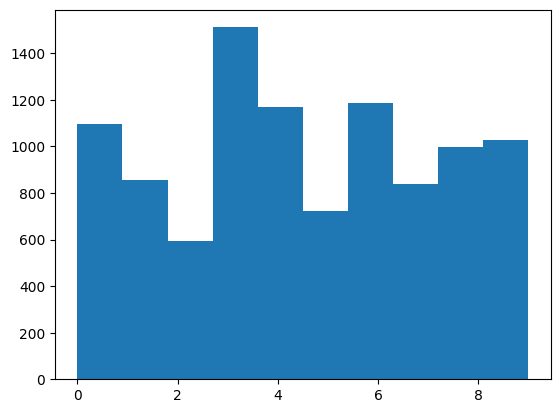

In [31]:
# adapt on all entropy samples
start=time.time()
acc_total, outputs_total = get_stats(model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
end=time.time()
print(f'total_error : {(1-acc_total)*100:.2f}') 
print(f'{end - start:.0f}s')

plt.hist(outputs_total.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')

### adaptation with suitable dataset (low)

low_error : 13.20
high_error : 44.98
total_error : 29.09
23s


(array([489., 543., 361., 399., 431., 511., 574., 594., 563., 535.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7fe916056c40>])

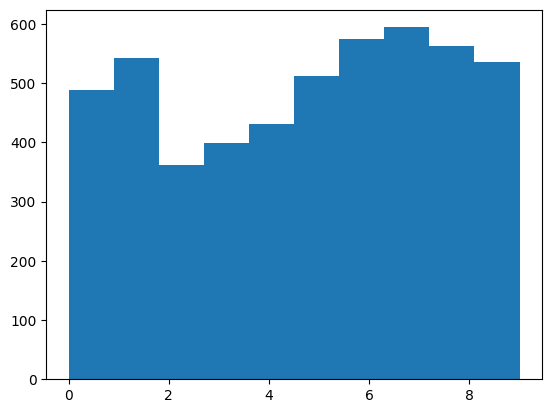

In [32]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
start=time.time()
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'low_error : {(1-acc_low)*100:.2f}')  

# without updating, check on high entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'high_error : {(1-acc_high)*100:.2f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total)*100:.2f}') 

end=time.time()
print(f'{end - start:.0f}s')

plt.hist(outputs_low.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')


                 0
count  4340.000000
mean     -6.945505
std       2.101445
min     -13.612392
25%      -8.404814
50%      -7.177088
75%      -5.620257
max       0.021082
                0
count  660.000000
mean    -4.617217
std      2.396273
min    -12.060491
25%     -6.378785
50%     -4.506184
75%     -2.753090
max     -0.078186


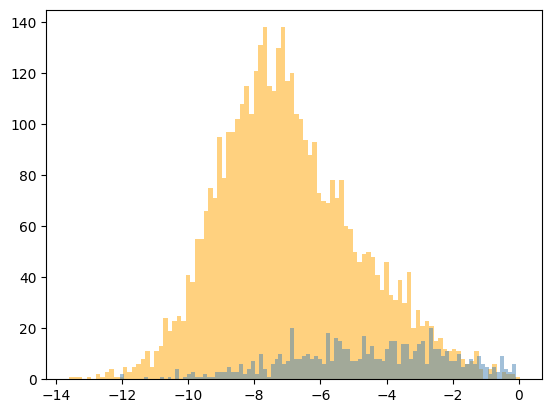

In [33]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  2751.000000
mean     -3.869989
std       3.034792
min     -14.717482
25%      -6.074655
50%      -3.400186
75%      -1.244377
max       0.908227
                 0
count  2249.000000
mean     -1.691987
std       2.083769
min     -11.611692
25%      -2.631215
50%      -0.907144
75%      -0.201707
max       0.974405


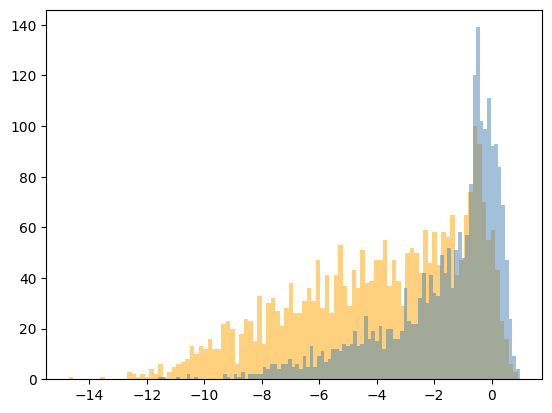

In [34]:
vis_entropy_histogram(outputs_high, y_high)

### adaptation with suitable dataset (high)

low_error : 13.28
high_error : 42.56
total_error : 27.92


(array([534., 278., 321., 497., 489., 599., 756., 540., 503., 483.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7fe9122c73a0>])

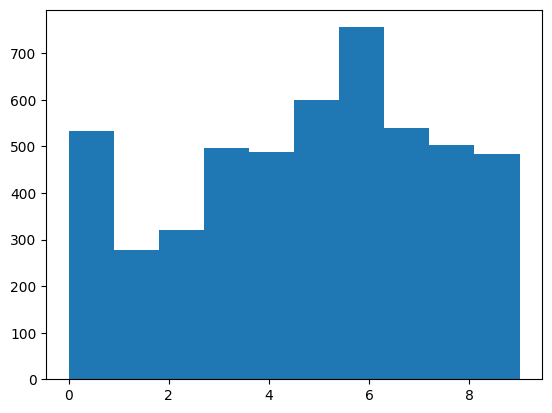

In [35]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)

# without updating, check on high entropy samples
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'low_error : {(1-acc_low)*100:.2f}')  
print(f'high_error : {(1-acc_high)*100:.2f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total)*100:.2f}') 

plt.hist(outputs_high.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')

                 0
count  4336.000000
mean     -8.165545
std       2.904706
min     -15.224570
25%     -10.070981
50%      -8.862155
75%      -6.903477
max       0.762830
                0
count  664.000000
mean    -3.845403
std      3.353184
min    -13.712125
25%     -6.245210
50%     -2.982612
75%     -0.901072
max      0.596229


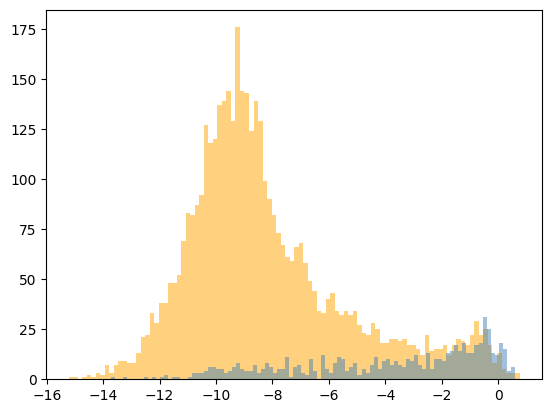

In [36]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  2872.000000
mean     -4.229777
std       3.237316
min     -15.013103
25%      -6.667952
50%      -3.694375
75%      -1.415065
max       0.837538
                 0
count  2128.000000
mean     -1.972481
std       2.438181
min     -11.909212
25%      -3.037703
50%      -1.104508
75%      -0.241820
max       0.984948


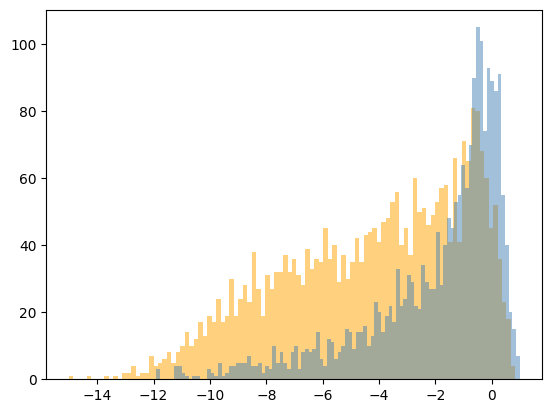

In [37]:
vis_entropy_histogram(outputs_high, y_high)

(array([534., 278., 321., 497., 489., 599., 756., 540., 503., 483.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 [<matplotlib.patches.Polygon at 0x7fe91227b7f0>])

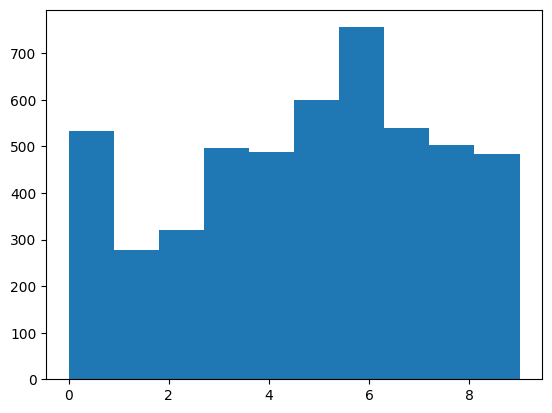

In [38]:
plt.hist(outputs_high.argmax(1), bins=10, density=False, histtype='stepfilled', edgecolor='none')